In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [8]:
df = pd.read_csv('/Users/mikhailkiselyov/code/thesis/nn-slam-benchmark/measurements/orin.csv')
df['quantized'] = df['quantized'].map({True: "int8", False: "fp32"})
resize_order = [200, 300, 400, 600, 800]
models = df['model'].unique()

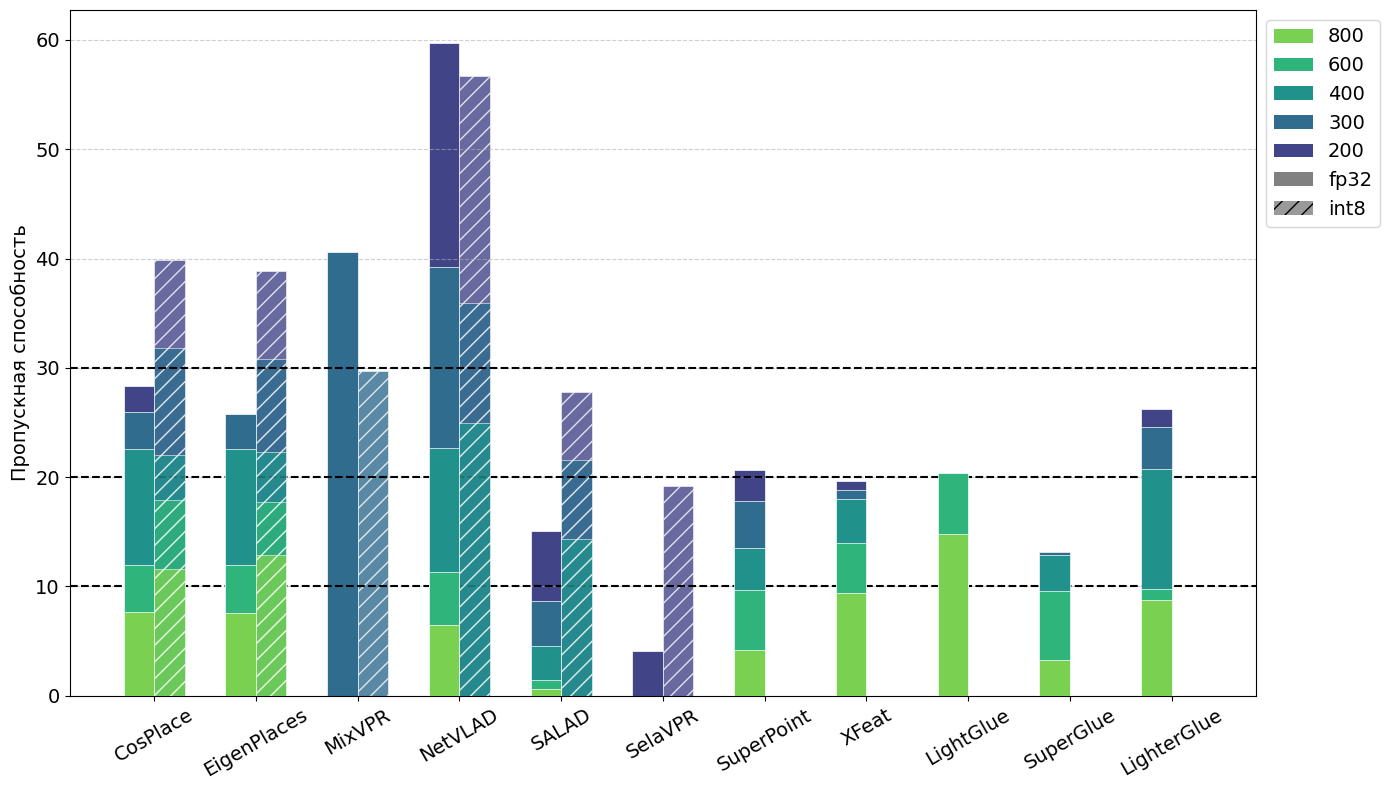

In [65]:
df = pd.read_csv('/Users/mikhailkiselyov/code/thesis/nn-slam-benchmark/measurements/orin30.csv')
df['quantized'] = df['quantized'].map({True: "int8", False: "fp32"})
models = df['model'].unique()
resize_order = [800, 600, 400, 300, 200]  # Ordered from front to back
# Create colormap for different resize values (lighter colors for front bars)
colors = plt.cm.viridis(np.linspace(0.8, 0.2, len(resize_order)))

# Create plot
plt.figure(figsize=(14, 8))
bar_width = 0.35
bar_width = 0.3
x_pos = np.arange(len(models))
bar_padding = 0.015  # Small gap between overlapping bars
bar_padding = 0  # Small gap between overlapping bars

# Plot fp32 bars (left side)
for i, resize in enumerate(resize_order):
    values = df[(df['resize'] == resize) & (df['quantized'] == 'fp32')]
    values = values.set_index('model')['throughput'].reindex(models, fill_value=0)
    
    plt.bar(
        x_pos - bar_width/2 - (i * bar_padding), 
        values.values,
        width=bar_width - (i * bar_padding * 0.8),  # Slightly narrower bars in back
        color=colors[i],
        edgecolor='white',
        linewidth=0.5,
        zorder=len(resize_order)-i,  # Higher zorder means in front
        label=f'{resize} fp32'
    )

# Plot int8 bars (right side)
for i, resize in enumerate(resize_order):
    values = df[(df['resize'] == resize) & (df['quantized'] == 'int8')]
    values = values.set_index('model')['throughput'].reindex(models, fill_value=0)
    
    plt.bar(
        x_pos + bar_width/2 + (i * bar_padding), 
        values.values,
        width=bar_width - (i * bar_padding * 0.8),  # Slightly narrower bars in back
        color=colors[i],
        edgecolor='white',
        linewidth=0.5,
        hatch='//',
        alpha=0.8,
        zorder=len(resize_order)-i,  # Higher zorder means in front
        label=f'{resize} int8'
    )

# Customize plot
# plt.xlabel('Method', fontsize=12)
plt.ylabel('Пропускная способность', fontsize=14)
# plt.title('Throughput Comparison (front: 800 → back: 200)', fontsize=14)
# plt.xticks(x_pos, models, rotation=20, ha='right')
plt.xticks(x_pos, models, fontsize=14, rotation=30)
plt.yticks(fontsize=14)

# Create custom legend
from matplotlib.patches import Patch
legend_elements = []
for i, resize in enumerate(resize_order):
    legend_elements.append(Patch(facecolor=colors[i], label=f'{resize}'))
legend_elements.append(Patch(facecolor='gray', label='fp32'))
legend_elements.append(Patch(facecolor='gray', hatch='//', alpha=0.8, label='int8'))

plt.legend(handles=legend_elements, bbox_to_anchor=(1.0, 1), loc='upper left', fontsize=14)

plt.grid(True, axis='y', linestyle='--', alpha=0.6)
# Horizontal line at y=10
plt.axhline(y=10, color='k', linestyle='--')
plt.axhline(y=20, color='k', linestyle='--')
plt.axhline(y=30, color='k', linestyle='--')
plt.tight_layout()
plt.show()

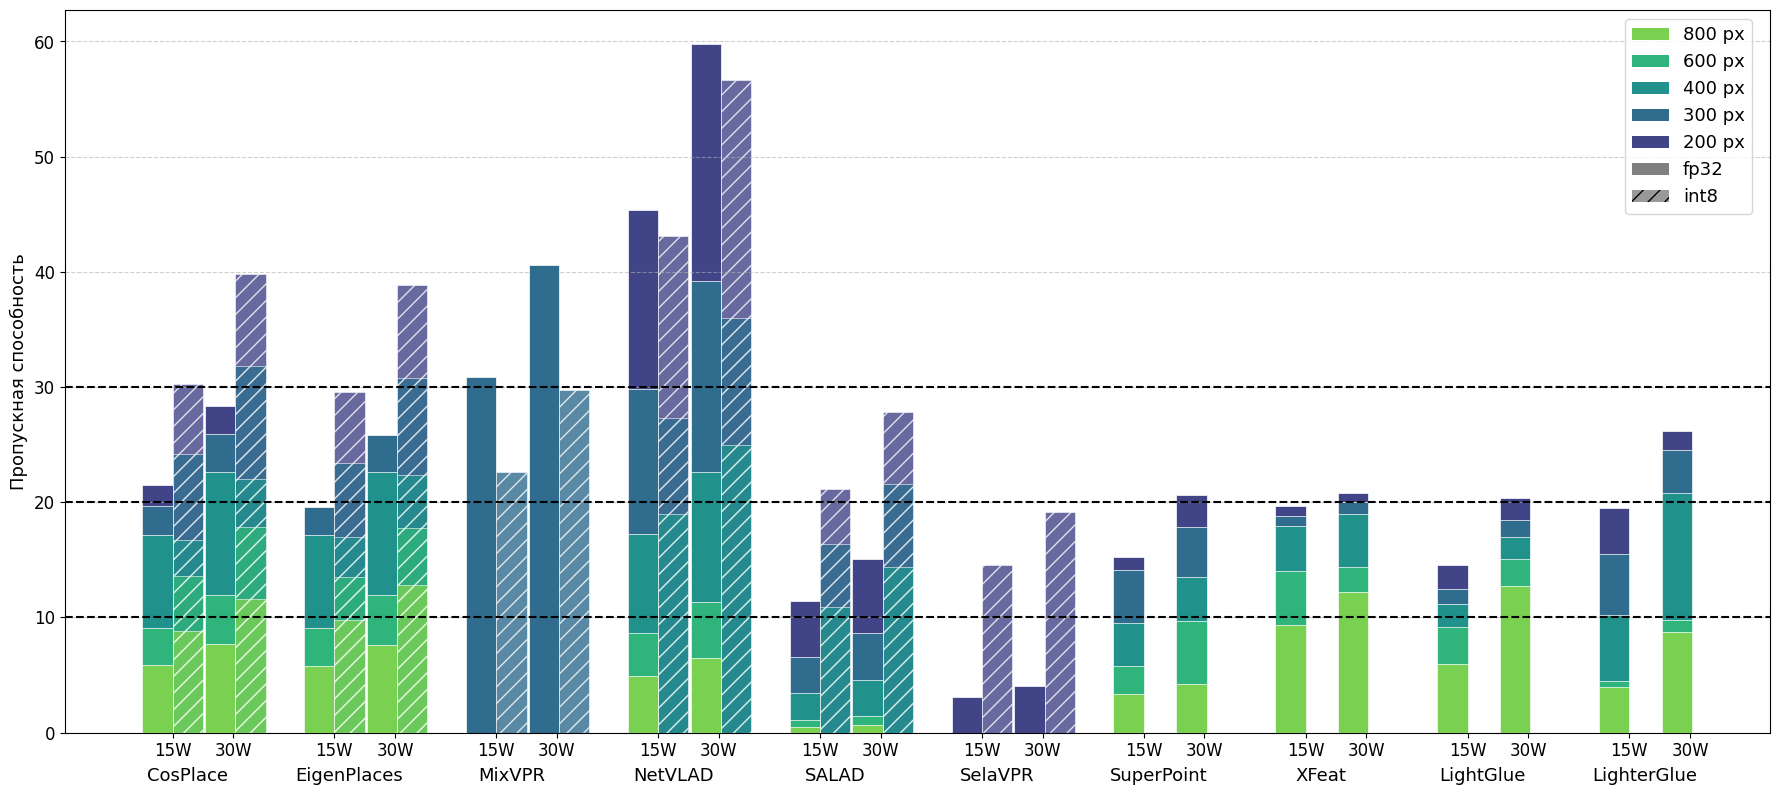

In [82]:

df = pd.read_csv('/Users/mikhailkiselyov/code/thesis/nn-slam-benchmark/measurements/orin-fake.csv')
skip_models = ["SuperGlue"]
# Prepare data
df['quantized'] = df['quantized'].map({True: 'int8', False: 'fp32'})
df = df[~df['model'].isin(skip_models)]
resize_order = [800, 600, 400, 300, 200]  # Front to back order
power_modes = sorted(df['power'].unique())
models = df['model'].unique()
# Filter out unwanted models

# Create colormap for resize values
colors = plt.cm.viridis(np.linspace(0.8, 0.2, len(resize_order)))

# Setup plot
plt.figure(figsize=(18, 8))
bar_width = 0.15
group_width = len(power_modes) * bar_width * 1.5  # Width for one method group
method_gap = 0.5  # Gap between method groups
power_mode_gap = 0.01  # Gap between power modes

# Calculate x positions
x_pos = []
current_pos = 0
for model in models:
    for power in power_modes:
        x_pos.append(current_pos)
        current_pos += bar_width
    current_pos += method_gap - (len(power_modes) * bar_width) + bar_width/2

# Plotting
for model_idx, model in enumerate(models):
    for power_idx, power in enumerate(power_modes):
        # Base x position for this power mode within method group
        base_x = model_idx * (len(power_modes) * bar_width + method_gap) + power_idx * bar_width * len(power_modes) + power_mode_gap*(power_idx)
        
        # Plot fp32 bars (left side)
        for i, resize in enumerate(resize_order):
            val = df[(df['model'] == model) & 
                    (df['power'] == power) & 
                    (df['quantized'] == 'fp32') & 
                    (df['resize'] == resize)]['throughput']
            if not val.empty:
                plt.bar(
                    base_x - bar_width/2, 
                    val.values[0],
                    width=bar_width,
                    color=colors[i],
                    edgecolor='white',
                    linewidth=0.5,
                    zorder=len(resize_order)-i,
                    label=f'{resize} fp32' if model_idx == 0 and power_idx == 0 and i == 0 else ''
                )
        
        # Plot int8 bars (right side)
        for i, resize in enumerate(resize_order):
            val = df[(df['model'] == model) & 
                    (df['power'] == power) & 
                    (df['quantized'] == 'int8') & 
                    (df['resize'] == resize)]['throughput']
            if not val.empty:
                plt.bar(
                    base_x + bar_width/2, 
                    val.values[0],
                    width=bar_width,
                    color=colors[i],
                    edgecolor='white',
                    linewidth=0.5,
                    hatch='//',
                    alpha=0.8,
                    zorder=len(resize_order)-i,
                    label=f'{resize} int8' if model_idx == 0 and power_idx == 0 and i == 0 else ''
                )

# X-axis labeling
xticks = []
xticklabels = []
current_pos = 0
for model in models:
    for power in power_modes:
        xticks.append(current_pos)
        xticklabels.append(f"{power}W")
        current_pos += bar_width * 2
    # current_pos += method_gap - ((len(power_modes)) * bar_width) - bar_width/2
    current_pos += method_gap - len(power_modes) * bar_width

plt.xticks(xticks, xticklabels, rotation=0, fontsize=12)
plt.yticks(fontsize=12)


# Add method group labels
for i, model in enumerate(models):
    group_center = i * (len(power_modes) * bar_width + method_gap) + (len(power_modes) * bar_width)/2 - bar_width/2
    plt.text(group_center, -max(df['throughput'])*0.05, model, 
             ha='center', va='top', fontsize=13)

# Customize plot
# plt.xlabel('Power Mode', fontsize=12)
plt.ylabel('Пропускная способность', fontsize=13)
# plt.title('Throughput Comparison by Method, Power Mode, and Quantization', fontsize=14)
# plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# Create custom legend
from matplotlib.patches import Patch
legend_elements = []
for i, resize in enumerate(resize_order):
    legend_elements.append(Patch(facecolor=colors[i], label=f'{resize} px'))
legend_elements.append(Patch(facecolor='gray', label='fp32'))
legend_elements.append(Patch(facecolor='gray', hatch='//', alpha=0.8, label='int8'))

plt.legend(handles=legend_elements, bbox_to_anchor=(0.91, 1), loc='upper left', fontsize=13)
# plt.legend(handles=legend_elements, bbox_to_anchor=(1.0, 1), loc='upper left')

plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.axhline(y=10, color='k', linestyle='--', zorder=5)
plt.axhline(y=20, color='k', linestyle='--', zorder=5)
plt.axhline(y=30, color='k', linestyle='--', zorder=5)
plt.tight_layout()
# plt.subplots_adjust(bottom=0.2)  # Make room for method labels

plt.show()